# Подготовка данных

Установим необходимые библиотеки

In [1]:
#Установим keras (если необходимо)
!pip install keras

#Установим tensorflow (если необходимо)
!pip install tensorflow

#Установим библиотеку для отображения изменения accuracy и loss
!pip install livelossplot

Импорт библиотек

In [2]:
#Загрузим необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import zipfile

import cv2
from imageio import imread

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.compiler.tensorrt import trt_convert as trt

from livelossplot.tf_keras import PlotLossesCallback
import warnings

In [3]:
#Если работаем через google disk
#Подключимся к диску с данными
# from google.colab import drive
# drive.mount('/content/gdrive')
# dir_path = '/content/gdrive/MyDrive/NN_Emotion_Rec'

#Если работаем через JupiterNotebook
dir_path = '.'
#Создадим путь до train
base_dir = dir_path + '/train'
test_dir = dir_path + '/test'

In [4]:
# #Архив с данными
# zip_file = dir_path + '/train.zip'

In [5]:
# #Распакуем
# z = zipfile.ZipFile(zip_file, 'r')
# z.extractall()

In [20]:
# #Создадим путь до файлов train, все изображения находятся в папке 'train'
# # base_dir = Path(dir_path + '/train')

# base_dir = Path().parent / 'train'

# train_anger_dir = base_dir / 'anger'
# train_contempt_dir = base_dir / 'contempt'
# train_disgust_dir = base_dir / 'disgust'
# train_fear_dir = base_dir / 'fear'
# train_happy_dir = base_dir / 'happy'
# train_neutral_dir = base_dir / 'neutral'
# train_sad_dir = base_dir / 'sad'
# train_surprise_dir = base_dir / 'surprise'
# train_uncertain_dir = base_dir / 'uncertain'

In [4]:
#Загрузим датасет
train_df = pd.read_csv(dir_path + '/skillbox-computer-vision-project/train.csv', sep=',').set_index('Unnamed: 0')

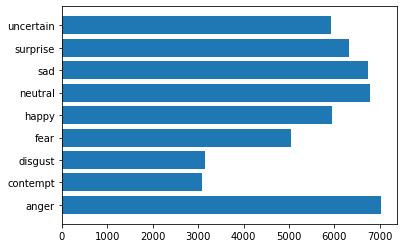

In [5]:
#Посмотрим на распределение признаков

plt.barh(train_df.groupby('emotion').count().index, train_df.groupby('emotion').count()['image_path'])
plt.show()

-----

Подготовим различные дополнительные функции

In [6]:
#Функция для отображения человека и эмоции
def human_emotion_show(images, labels, predicted_labels=None):
    names = {v:k for k, v in train_data.class_indices.items()} #Словарь с эмоциями (ключ:значение -> значение:ключ)
    
    fig = plt.figure(figsize=(12,12))
    for i in range(20):
        plt.subplot(5,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(images[i])
        
        if predicted_labels is not None:
            title_obj = plt.title(
                f'Real: {names[np.argmax(labels[i])]} \n Pred: {names[np.argmax(predicted_labels[i])]}'
            )
            if np.argmax(labels[i]) != np.argmax(predicted_labels[i]):
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Emotion: {names[np.argmax(labels[i])]}")
    fig.tight_layout()
    


#Функция для предобработки изображения для prediction
def prepare_image(img, new_size):
    #Конвертирование в Ч/Б
    img = tf.image.rgb_to_grayscale(img)
    
    #Изменение размера
    img = tf.image.resize(img, new_size) /255.
    return np.array(img)

------

# Нейронная сеть

Для нахождения наилучшего решения, выберем архитектуру VGG19 и загрузим веса imagenet. После чего дообучим на наших данных. Cделаем свой препроцессинг с аугментацией.

## VGG19

Препроцессинг и аугментация

In [7]:
from tensorflow.keras.applications.vgg19 import preprocess_input

In [8]:
#Зададим размер batch и размер изображения

BATCH_SIZE = 128
IMG_SHAPE  = 128

In [9]:
#Создадим необходимые train (80%) и validation (20%) datasets
#Зададим некоторые параметры аугментации

data_image_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=30, #Добавить поворот
                                    shear_range=0.2, #Добавить сдвиг
                                    zoom_range=0.2, #Добавить увеличение
                                    horizontal_flip=True, #Добавить зеркальный поворот
                                    fill_mode="nearest", #Заполняем пробелы
                                    validation_split=0.2)


train_data = data_image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=base_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                class_mode='categorical', 
                                                subset='training')

valid_data = data_image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                                directory=base_dir, 
                                                shuffle=False, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                class_mode='categorical', 
                                                subset='validation')

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


In [10]:
#Изображения и лэйблы
train_images, train_labels = next(train_data)
val_images, val_labels = next(valid_data)

print(f' Размер train_data: {train_images.shape}','\n', f'Размер train_labels: {train_labels.shape}','\n')
print(f' Размер validation_data: {val_images.shape}','\n', f'Размер validation_labels: {val_labels.shape}')

 Размер train_data: (128, 128, 128, 3) 
 Размер train_labels: (128, 9) 

 Размер validation_data: (128, 128, 128, 3) 
 Размер validation_labels: (128, 9)


In [11]:
#Количество определенных эмоций (по сути, кол-во классов)
n_emotions = train_labels.shape[1]
n_emotions

9

Формируем архитектуру нейронной сети на основе сети VGG19

----

In [35]:
model_base_VGG19 = tf.keras.applications.VGG19(input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
                                               include_top = False, #Отключим входной слой, чтобы задать свои размеры
                                               weights='imagenet')

In [36]:
#Не замораживаем слои, так как imagnet содержит различные изображения
model_base_VGG19.trainable = True

model_base_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [37]:
#Допишем модель
#Указываем количество классов (n_emotion)
emotion_model_VGG19 = tf.keras.Sequential([model_base_VGG19,
                                           tf.keras.layers.GlobalAveragePooling2D(),
#                                            tf.keras.layers.Dense(512, activation='relu'), 
#                                            tf.keras.layers.Dropout(0.5), #Прореживаем нс для исключения переобучения
                                           tf.keras.layers.Dense(n_emotions, activation='softmax')]) 


#Параметры модели
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.categorical_accuracy

#Компиляция
emotion_model_VGG19.compile(optimizer=optim, 
                            loss=loss, 
                            metrics=metric)

In [27]:
#Сохраним наилучший результат модели

model_best_path = Path('model_emotion_best_VGG19')
model_best_path.mkdir(exist_ok=True)

model_best_filename = 'checkpoint_best.h5'  
model_best_path_total = str(model_best_path/model_best_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_best_path_total, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

**Обучение модели**

___

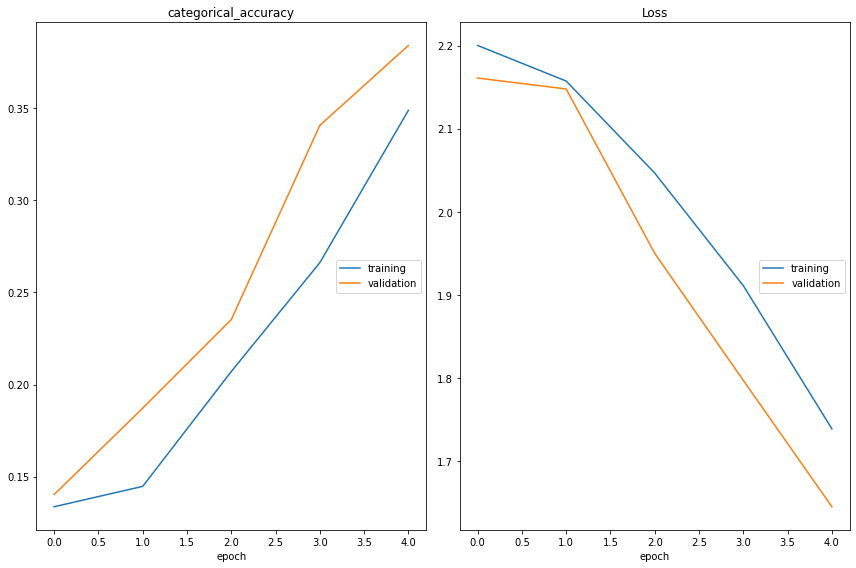

categorical_accuracy
	training         	 (min:    0.134, max:    0.349, cur:    0.349)
	validation       	 (min:    0.140, max:    0.384, cur:    0.384)
Loss
	training         	 (min:    1.739, max:    2.200, cur:    1.739)
	validation       	 (min:    1.645, max:    2.161, cur:    1.645)
313/313 [==============================] - 509s 2s/step - loss: 1.7387 - categorical_accuracy: 0.3488 - val_loss: 1.6450 - val_categorical_accuracy: 0.3840


In [28]:
EPOCHS = 5

history = emotion_model_VGG19.fit(train_data,
                                  validation_data=valid_data, 
                                  epochs=EPOCHS, 
                                  callbacks=[checkpoint, PlotLossesCallback()])

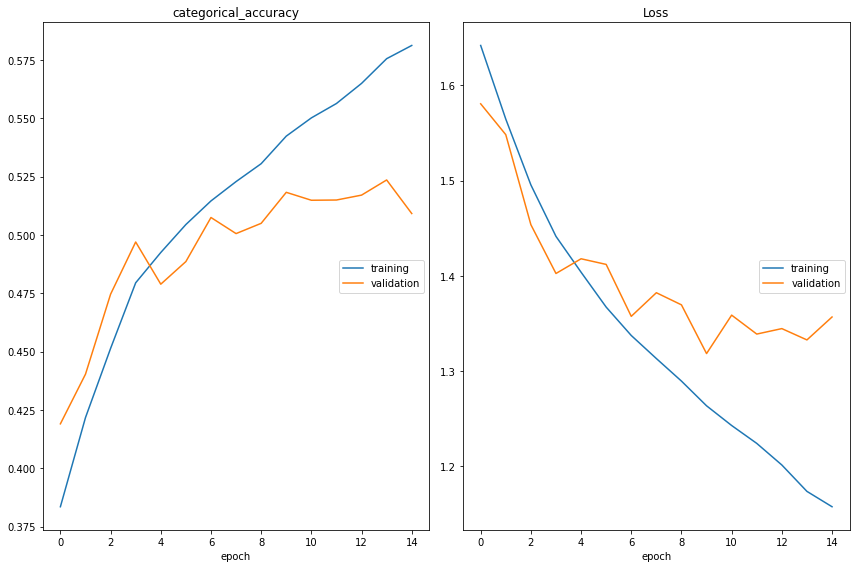

categorical_accuracy
	training         	 (min:    0.383, max:    0.581, cur:    0.581)
	validation       	 (min:    0.419, max:    0.524, cur:    0.509)
Loss
	training         	 (min:    1.158, max:    1.642, cur:    1.158)
	validation       	 (min:    1.318, max:    1.581, cur:    1.357)
313/313 [==============================] - 509s 2s/step - loss: 1.1577 - categorical_accuracy: 0.5812 - val_loss: 1.3569 - val_categorical_accuracy: 0.5091


In [29]:
EPOCHS = 15

history = emotion_model_VGG19.fit(train_data,
                                  validation_data=valid_data, 
                                  epochs=EPOCHS, 
                                  callbacks=[checkpoint, PlotLossesCallback()])

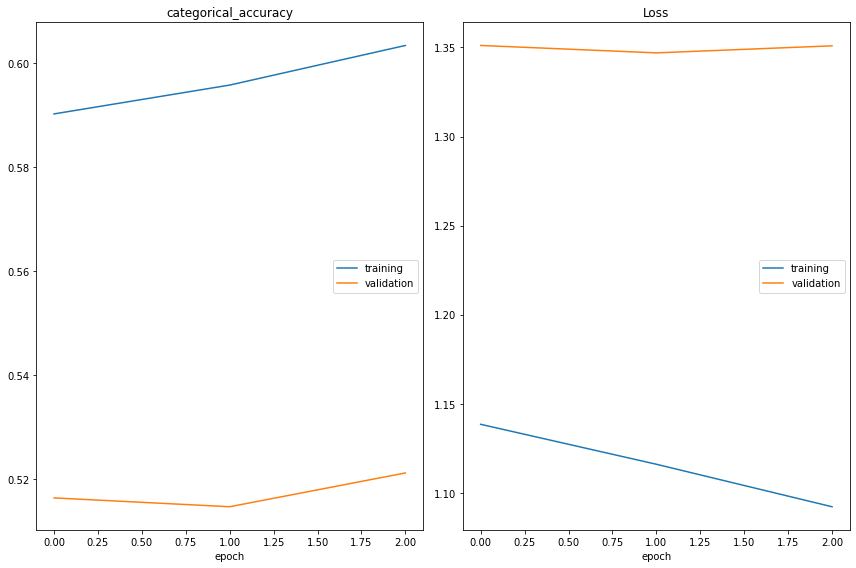

categorical_accuracy
	training         	 (min:    0.590, max:    0.603, cur:    0.603)
	validation       	 (min:    0.515, max:    0.521, cur:    0.521)
Loss
	training         	 (min:    1.092, max:    1.138, cur:    1.092)
	validation       	 (min:    1.347, max:    1.351, cur:    1.351)
313/313 [==============================] - 551s 2s/step - loss: 1.0922 - categorical_accuracy: 0.6033 - val_loss: 1.3509 - val_categorical_accuracy: 0.5211


In [30]:
EPOCHS = 3

history = emotion_model_VGG19.fit(train_data,
                                  validation_data=valid_data, 
                                  epochs=EPOCHS, 
                                  callbacks=[checkpoint, PlotLossesCallback()])

In [31]:
#Сохранить веса (если возникли сложности с чекпоинтом)
emotion_model_VGG19.save(dir_path + '/model_emotion_best_VGG19/' + model_best_filename)

#Сохранить модель
emotion_model_VGG19.save(dir_path + '/model_emotion_best_VGG19/best_model')

Посмотрим на результаты работы модели

In [15]:
#Загрузим веса
emotion_model_VGG19.load_weights(dir_path + '/model_emotion_best_VGG19/checkpoint_best.h5')

# #Загрузить модель
# model = tf.keras.models.load_model(dir_path + '/model_emotion_best_VGG19/best_model')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

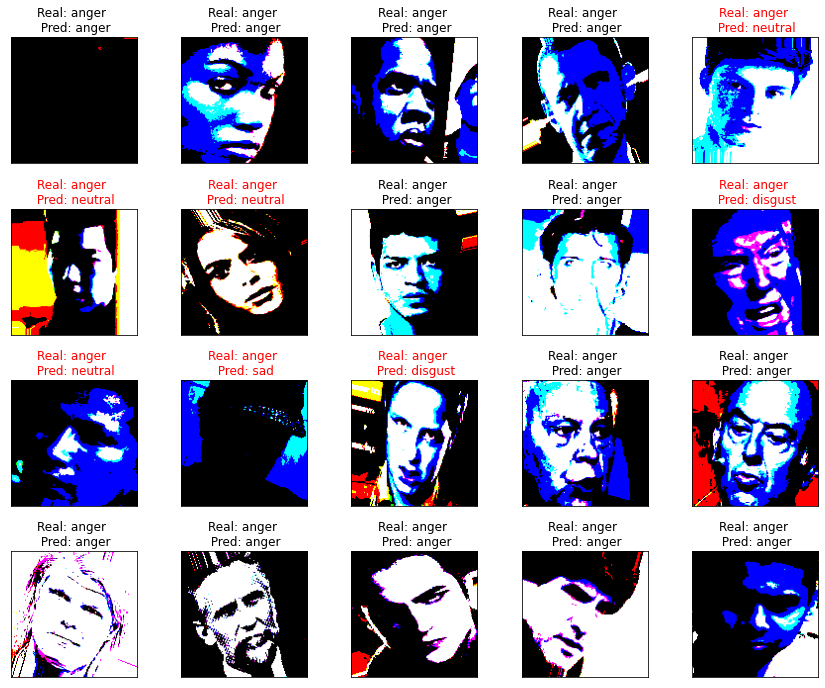

In [16]:
#Предсказание модели
val_predictions = emotion_model_VGG19.predict(val_images)

#Визуализация
human_emotion_show(val_images, val_labels, val_predictions)

----

# Выводы по всей работе

Обучено 35 эпох.

Одна эпоха обучается порядка 10 минут. 

На валидационной выборке **точность 52%**, loss 1.35. 